* Παναγιώτης Ζευγολατάκος 03117804
* Χατζηθεοδώρου Ιάσων 03117089
* Ανδρέας Βεζάκης 03117186

# Πρώτη Άσκηση

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Εισαγωγή βιβλιοθηκών

In [ ]:
from io import StringIO
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_validate,learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## Εισαγωγή δεδομένων

In [ ]:
# read data into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/Lab1/xaa.dat', sep="\s+", header=None)

for letter in 'bcdefghi':
    temp = pd.read_csv('/content/drive/MyDrive/Lab1/xa' + letter + '.dat', sep="\s+", header=None)
    data = pd.concat([data, temp], ignore_index=True)
    
data.name = 'data'
data.columns = ['Compactness', 'Circularity', 'Dist. Circ.', 'Rad. Ratio', 'Pr. Axis Asp. Ratio', 'Max. Len. Asp. Ratio', 'Scatter Ratio', 'Elongatedness', 'Pr. Axis Rect.', 'Max. Len. Rect.', 'Scaled Var. Maj. Ax.', 'Scaled Var Min. Ax.', 'Scaled Rad. Gyr.', 'Skew. Maj. Axis', 'Skew. Min. Axis.', 'Kurt. Min. Axis', 'Kurt. Maj. Axis', 'Hollows Ratio', 'Result']  
print(data)

     Compactness  Circularity  ...  Hollows Ratio  Result
0             95           48  ...            197     van
1             91           41  ...            199     van
2            104           50  ...            196    saab
3             93           41  ...            207     van
4             85           44  ...            183     bus
..           ...          ...  ...            ...     ...
841           93           39  ...            195    saab
842           89           46  ...            197     van
843          106           54  ...            201    saab
844           86           36  ...            195    saab
845           85           36  ...            190     van

[846 rows x 19 columns]


## Παρουσίαση Dataset

Το παρόν dataset προέρχεται από το ινστιτούτο Turing στη Γλασκόβη, Σκωτία. Τα δεδομένα που περιέχει συγκεντρώθηκαν στο ινστιτούτο το 1986-87 και ο αρχικός σκοπός ήταν να βρεθεί μέθοδος διαφοροποίησης μεταξύ τρισδιάστατων αντικειμένων σε μία δισδιάστατη φωτογραφία εφαρμόζοντας ένα σύνολο εξαγωγών χαρακτηριστικών σχήματος (shape feature extractors) στις δισδιάτατες σιλουέτες των αντικειμένων.

Το dataset περιέχει 846 δείγματα από 4 είδη οχημάτων:
- 2 αυτοκινήτα
    - SAAB
    - Opel
- βαν 
- λεωφορεία

και περιέχει 18 χαρακτηριστικά για το καθένα:
- Compactness
- Circularity
- Distance Circularity
- Radius Ratio
- Pr. Axis Aspect Ratio
- Max. Length Aspect Ratio
- Scatter Ratio
- Elongatedness
- Pr. Axis Rectangularity
- Max. Length Rectangularity
- Scaled Variance along Major Axis
- Scaled Variance along Minor Axis
- Scaled Radiusn of Gyration
- Skewness about Major Axis
- Skewness about Minor Axis
- Kurtosis about Minor Axis
- Kurtosis about Major Axis
- Hollows Ratio

τα οποία βρίσκονται στις πρώτες 18 κολώνες, ενώ στη 19η βρίσκεται το είδος του οχήματος.


Δε χρειάστηκε να γίνει μετατροπή στα αρχεία για την εισαγωγή τους.

Δεν υπήρχαν επικεφαλίδες, αρίθμηση γραμμών ή ετικέτες των κλάσεων.




In [ ]:
data['Result'].value_counts()

bus     218
saab    217
opel    212
van     199
Name: Result, dtype: int64

Υπάρχουν 4 κλάσεις, τα 4 είδη οχημάτων:
- opel (218 δείγματα - 25.77%)
- saab (217 δείγματα - 25.65%)
- bus  (212 δείγματα - 25.06%)
- van  (199 δείγματα - 23.52%)

Δε χρειάζεται να γίνει κάποιο sampling.

## Εύρερη απουσιάζουσων τιμών

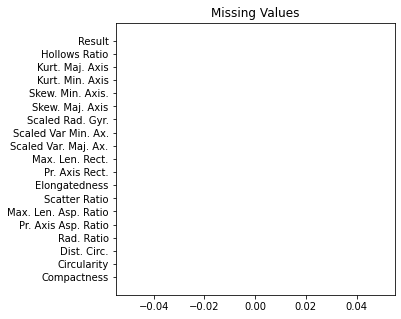

In [ ]:
# NaN occurences in vehicles.occutc
def count_nan(df, col):
    return df[col].isnull().sum()

def calculate_nan_per_column(df):
    keys = []
    values = []
    for k in df.keys():
        keys.append(k)
        values.append(count_nan(df, k) / df.shape[0] * 100)
    return keys, values

titles = ['characteristics', 'places', 'drivers', 'vehicles']

features, nans = calculate_nan_per_column(data)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

for idx in range(0, 19):
    ax.barh(features[idx], nans[idx])
    ax.title.set_text('Missing Values')

plt.show()

Όπως βλέπουμε παραπάνω δε λείπει καμία τιμή.

## Προεπεξεργασία

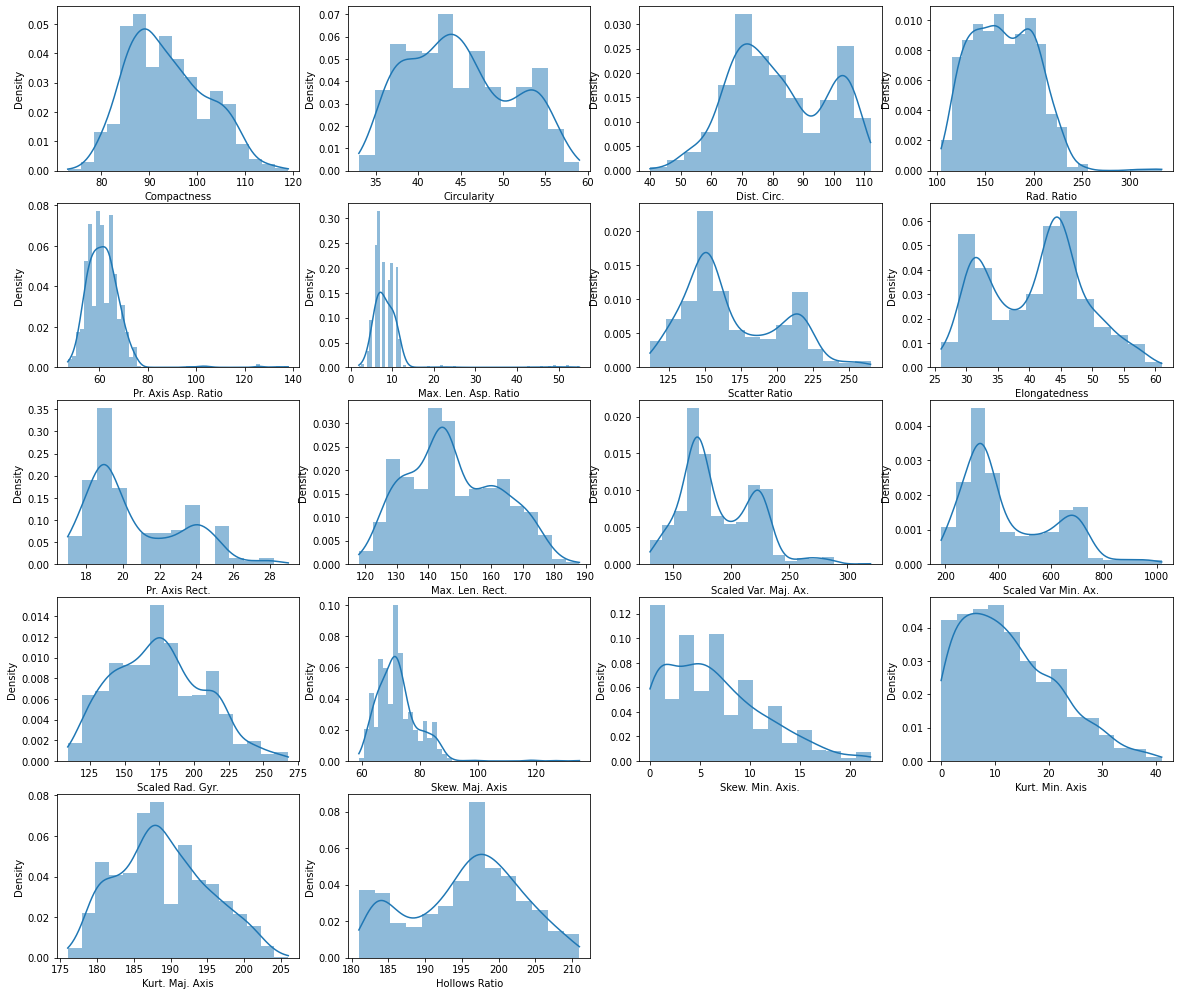

In [ ]:
def plot_value_frequencies(df, cols=4, figsize=(5, 3.5)):
    selected = df.select_dtypes(include=['float64','int64'])
    key_list = selected.keys()
    nkeys = len(key_list)
    columns = cols
    rows = nkeys // columns + 1
    
    figsize = (figsize[0] * columns, figsize[1] * rows)
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    ax_list = axs.ravel()
    for ax in ax_list:
        ax.set_axis_off()

    for i, k in enumerate(key_list):
        ax = ax_list[i]
        ax.set_axis_on()
        sns.histplot(df[k], label=k, ax=ax, kde=True, stat="density", linewidth=0)
        #df[k].value_counts().hist(ax=ax, bins=20)
        #ax.set_title(k)
    
    plt.show()

plot_value_frequencies(data)

Δεδομένων των παραπάνω κατανομών των δεδομένων καταλήγουμε πως δεν μπορεί να γίνει κάποια προεπεξεργασία/δεν μπορεί να αφαιρεθεί κάποιο χαρακτηριστικό.

## Χωρισμός των δεδομένων

Θα χωρίσουμε τα δεδομένα σε training set και testing set, με ποσοστό 70-30:

In [ ]:
X = np.array(data.drop(['Result'], axis=1))
y = np.array(data['Result'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Θα χρησιμοποιήσουμε τα παρακάτω scoring strategies:

In [ ]:
scoring_strategies = ['accuracy', 'f1_macro']

Θα χρησιμοποιήσουμε τους παρακάτω ταξινομητές:

In [ ]:
dummy_clf = DummyClassifier()
gnb_clf = GaussianNB()
knn_clf = KNeighborsClassifier()
log_clf = LogisticRegression()

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def out_of_the_box_evaluation(X_train, y_train):
    
    names = ['Dummy', 'Gaussian NB', 'k-Nearest Neighbors', 'Logistic Regression']

    scores = [  
              cross_validate(dummy_clf, X, y, cv=10, scoring=scoring_strategies),
                cross_validate(gnb_clf, X, y, cv=10, scoring=scoring_strategies),
                cross_validate(knn_clf, X, y, cv=10, scoring=scoring_strategies),
                cross_validate(log_clf, X, y, cv=10, scoring=scoring_strategies) ]

    return names, scores

In [ ]:
names, scores = out_of_the_box_evaluation(X_train, y_train)

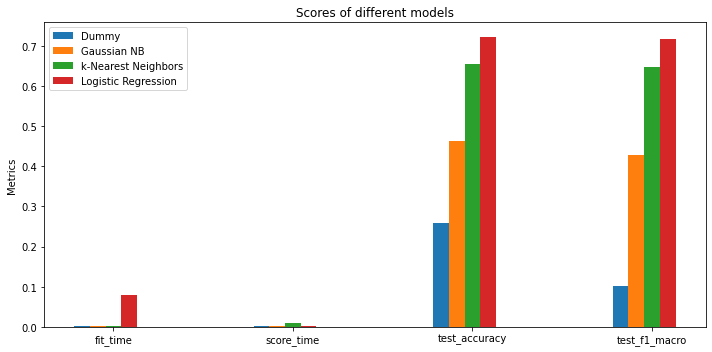

Dummy
fit_time: 0.00124
score_time: 0.00227
test_accuracy: 0.25770
test_f1_macro: 0.10244

Gaussian NB
fit_time: 0.00216
score_time: 0.00180
test_accuracy: 0.46319
test_f1_macro: 0.42713

k-Nearest Neighbors
fit_time: 0.00208
score_time: 0.01047
test_accuracy: 0.65496
test_f1_macro: 0.64807

Logistic Regression
fit_time: 0.07907
score_time: 0.00178
test_accuracy: 0.72231
test_f1_macro: 0.71752



In [ ]:
def plot_scores_of_models(scores, names):
    # Calculate mean of scores of the different folds
    avg_scores = []
    for s in scores:
        avg_scores_of_model = []
        for key in s:
            avg = s[key].mean()
            avg_scores_of_model.append(avg)
        avg_scores.append(avg_scores_of_model)

    # plot
    x = np.arange(len(avg_scores[0])) 
    width = 0.35
    window = width/len(avg_scores)
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, s in enumerate(avg_scores):
        ax.bar(x + (i - len(avg_scores)/2) * window, s, window, label=names[i])
    
    ax.set_ylabel('Metrics')
    ax.set_title('Scores of different models')
    ax.set_xticks(x)
    ax.set_xticklabels(scores[0].keys())
    ax.legend()

    fig.tight_layout()

    plt.show()

plot_scores_of_models(scores, names)

for name, score in zip(names, scores):
  print(name)
  for key in score.keys():
    avg = score[key].mean()
    print(f"{key}: {avg:.5f}")
  print("")

| Classifier | Fit time | Score time | Accuracy | F1 macro |
|------------|----------|------------|----------|-----------------|
| Dummy      |   0.00124     |   0.00227         |   0.25770       |     0.10244     |
| GNB        |   0.00216     |   0.00180         |   0.46319       |     0.42713     |
| kNN        |   0.00208     |   0.01047         |   0.65496       |     0.64807     |
| LogReg     |   0.07907     |   0.00178         |   0.72231       |     0.71752     |

## Pipelines

In [ ]:
preprocessor = make_pipeline(StandardScaler())
DummyPipeline = make_pipeline(preprocessor, DummyClassifier())
GNBPipeline = make_pipeline(preprocessor, GaussianNB())
kNNPipeline = make_pipeline(preprocessor, KNeighborsClassifier())
LogPipeline = make_pipeline(preprocessor, LogisticRegression())

In [ ]:
dict_of_models = {'Dummy': DummyPipeline,
                  'GNB': GNBPipeline,
                  'kNN': kNNPipeline,
                  'Log': LogPipeline}

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the predictions
    y_pred = model.predict(X_test)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

In [ ]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

---------------------------------
Dummy
Accuracy =  0.18503937007874016
-
[[ 0 78  0  0]
 [ 0 47  0  0]
 [ 0 71  0  0]
 [ 0 58  0  0]]
-
              precision    recall  f1-score   support

         bus       0.00      0.00      0.00        78
        opel       0.19      1.00      0.31        47
        saab       0.00      0.00      0.00        71
         van       0.00      0.00      0.00        58

    accuracy                           0.19       254
   macro avg       0.05      0.25      0.08       254
weighted avg       0.03      0.19      0.06       254

-
---------------------------------
GNB
Accuracy =  0.4566929133858268
-
[[ 9 25  2 42]
 [ 0 20 15 12]
 [ 2 17 31 21]
 [ 1  1  0 56]]
-
              precision    recall  f1-score   support

         bus       0.75      0.12      0.20        78
        opel       0.32      0.43      0.36        47
        saab       0.65      0.44      0.52        71
         van       0.43      0.97      0.59        58

    accuracy        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Εύρεση βέλτιστων υπερπαραμέτρων με αναζήτηση πλέγματος με διασταυρούμενη επικύρωση

Accuracy =  0.4566929133858268
-
[[ 9 25  2 42]
 [ 0 20 15 12]
 [ 2 17 31 21]
 [ 1  1  0 56]]
-
              precision    recall  f1-score   support

         bus       0.75      0.12      0.20        78
        opel       0.32      0.43      0.36        47
        saab       0.65      0.44      0.52        71
         van       0.43      0.97      0.59        58

    accuracy                           0.46       254
   macro avg       0.54      0.49      0.42       254
weighted avg       0.57      0.46      0.41       254

-


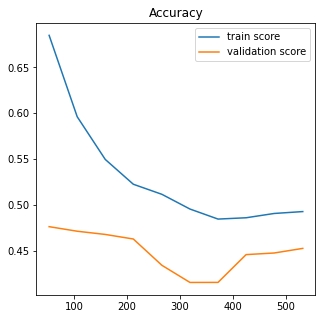

In [ ]:
parameters = { 
    'gaussiannb__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

gnb_grid = GridSearchCV(GNBPipeline, parameters, scoring='accuracy')
gnb_grid.fit(X_train, y_train)

best_gnb = (gnb_grid.best_estimator_)
best_gnb.fit(X_train,y_train)
# calculating the predictions
y_pred = best_gnb.predict(X_test)

N, train_score, test_score = learning_curve(best_gnb, X_train, y_train, 
                                           cv=10, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))
GNB_conf_matr = confusion_matrix(y_test,y_pred)
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')
    
plt.figure(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, test_score.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy')
plt.show()

Accuracy =  0.7086614173228346
-
[[72  5  0  1]
 [ 0 20 24  3]
 [ 3 29 32  7]
 [ 2  0  0 56]]
-
              precision    recall  f1-score   support

         bus       0.94      0.92      0.93        78
        opel       0.37      0.43      0.40        47
        saab       0.57      0.45      0.50        71
         van       0.84      0.97      0.90        58

    accuracy                           0.71       254
   macro avg       0.68      0.69      0.68       254
weighted avg       0.71      0.71      0.70       254

-


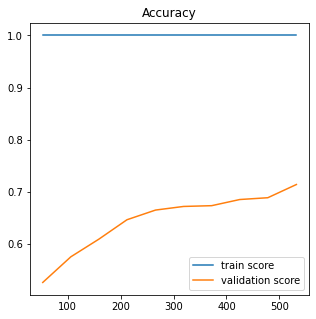

In [ ]:
parameters = { 
    'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

kNN_grid = GridSearchCV(kNNPipeline, parameters, scoring='accuracy', n_jobs=-1)
kNN_grid.fit(X_train, y_train)

best_kNN = (kNN_grid.best_estimator_)
best_kNN.fit(X_train,y_train)
# calculating the predictions
y_pred = best_kNN.predict(X_test)

N, train_score, test_score = learning_curve(best_kNN, X_train, y_train, 
                                           cv=10, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))
kNN_conf_matr = confusion_matrix(y_test,y_pred)
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')
    
plt.figure(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, test_score.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


400 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

Accuracy =  0.8149606299212598
-
[[77  0  0  1]
 [ 1 35 10  1]
 [ 4 27 39  1]
 [ 1  1  0 56]]
-
              precision    recall  f1-score   support

         bus       0.93      0.99      0.96        78
        opel       0.56      0.74      0.64        47
        saab       0.80      0.55      0.65        71
         van       0.95      0.97      0.96        58

    accuracy                           0.81       254
   macro avg       0.81      0.81      0.80       254
weighted avg       0.83      0.81      0.81       254

-


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



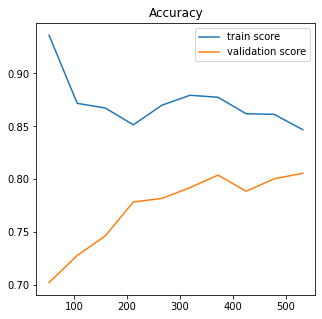

In [ ]:
parameters = {
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(1, 1, 10),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [2000]
}

Log_grid = GridSearchCV(LogPipeline, parameters, scoring='accuracy', n_jobs=-1)
Log_grid.fit(X_train, y_train)

best_Log = (Log_grid.best_estimator_)
best_Log.fit(X_train,y_train)
# calculating the predictions
y_pred = best_Log.predict(X_test)

N, train_score, test_score = learning_curve(best_Log, X_train, y_train, 
                                            cv=10, scoring='accuracy', 
                                            train_sizes=np.linspace(0.1,1,10))
Log_conf_matr = confusion_matrix(y_test,y_pred)
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')

plt.figure(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, test_score.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy')
plt.show()


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def optimised_evaluation(X_train, y_train):
    
    names = ['Gaussian NB', 'k-Nearest Neighbors', 'Logistic Regression']

    scores = [  
                cross_validate(best_gnb, X, y, cv=10, scoring=scoring_strategies),
                cross_validate(best_kNN, X, y, cv=10, scoring=scoring_strategies),
                cross_validate(best_Log, X, y, cv=10, scoring=scoring_strategies) ]

    return names, scores

names, scores = optimised_evaluation(X_train, y_train)

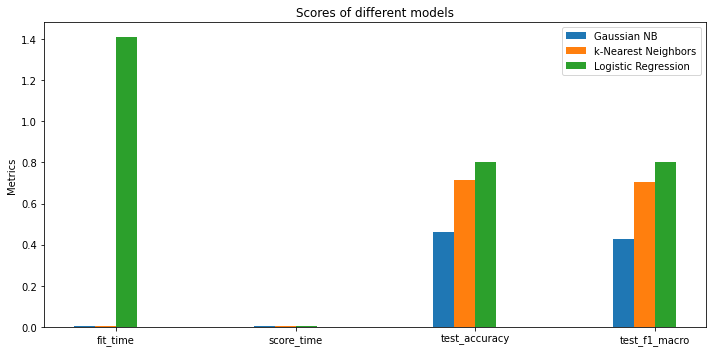

Gaussian NB
fit_time: 0.00404
score_time: 0.00197
test_accuracy: 0.46319
test_f1_macro: 0.42727

k-Nearest Neighbors
fit_time: 0.00223
score_time: 0.00402
test_accuracy: 0.71410
test_f1_macro: 0.70364

Logistic Regression
fit_time: 1.41028
score_time: 0.00199
test_accuracy: 0.80277
test_f1_macro: 0.80193



In [ ]:
plot_scores_of_models(scores, names)

for name, score in zip(names, scores):
  print(name)
  for key in score.keys():
    avg = score[key].mean()
    print(f"{key}: {avg:.5f}")
  print("")

## Συνοπτική σύγκριση out of the box evaluation με τους βελτιστοποιημένους classifiers

| Classifier | Fit time | Score time | Accuracy | F1 macro |
|------------|----------|------------|----------|-----------------|
| GNB (out of the box)      |   0.00216     |   0.00180         |   0.46319       |     0.42713     |
| GNB        |   0.00404     |   0.00197         |   0.46319       |     0.42727     |
| kNN (out of the box)        |   0.00208     |   0.01047         |   0.65496       |     0.64807     |
| kNN     |   0.00223     |   0.00402         |   0.71410       |     0.70364     |
| LogReg (out of the box)      |   0.07907     |   0.00178         |   0.72231       |     0.71752     |
| LogReg        |   1.41028     |   0.00199         |   0.80277       |     0.80193     |


Παρατηρούμε σαφή αύξηση του accuracy και του F1 macro σε όλες τους classifiers, με εξαίρεση τον Gaussian Naive-Bayes, εφόσον η μόνη παράμετρος που βοηθάει στην επίδοσή του είναι η var_smoothing, η οποία όπως φαίνεται δεν επηρεάζει σχεδόν καθόλου τα αποτελέσματα.

## Pipelines (with PCA)

In [ ]:
preprocessor = make_pipeline(PCA(n_components=5), StandardScaler())
DummyPipeline = make_pipeline(preprocessor, DummyClassifier())
GNBPipeline = make_pipeline(preprocessor, GaussianNB())
kNNPipeline = make_pipeline(preprocessor, KNeighborsClassifier())
LogPipeline = make_pipeline(preprocessor, LogisticRegression())

In [ ]:
dict_of_models = {'Dummy': DummyPipeline,
                  'GNB': GNBPipeline,
                  'kNN': kNNPipeline,
                  'Log': LogPipeline}

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the predictions
    y_pred = model.predict(X_test)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

In [ ]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

---------------------------------
Dummy
Accuracy =  0.18503937007874016
-
[[ 0 78  0  0]
 [ 0 47  0  0]
 [ 0 71  0  0]
 [ 0 58  0  0]]
-
              precision    recall  f1-score   support

         bus       0.00      0.00      0.00        78
        opel       0.19      1.00      0.31        47
        saab       0.00      0.00      0.00        71
         van       0.00      0.00      0.00        58

    accuracy                           0.19       254
   macro avg       0.05      0.25      0.08       254
weighted avg       0.03      0.19      0.06       254

-
---------------------------------
GNB
Accuracy =  0.4566929133858268
-
[[27 13  2 36]
 [ 5 21 12  9]
 [11 27 23 10]
 [ 2  6  5 45]]
-
              precision    recall  f1-score   support

         bus       0.60      0.35      0.44        78
        opel       0.31      0.45      0.37        47
        saab       0.55      0.32      0.41        71
         van       0.45      0.78      0.57        58

    accuracy        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy =  0.4566929133858268
-
[[27 13  2 36]
 [ 5 21 12  9]
 [11 27 23 10]
 [ 2  6  5 45]]
-
              precision    recall  f1-score   support

         bus       0.60      0.35      0.44        78
        opel       0.31      0.45      0.37        47
        saab       0.55      0.32      0.41        71
         van       0.45      0.78      0.57        58

    accuracy                           0.46       254
   macro avg       0.48      0.47      0.45       254
weighted avg       0.50      0.46      0.45       254

-


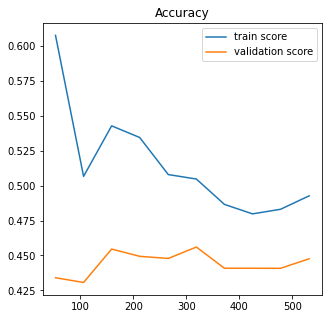

In [ ]:
parameters = { 
    'gaussiannb__var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

gnb_grid = GridSearchCV(GNBPipeline, parameters, scoring='accuracy')
gnb_grid.fit(X_train, y_train)

best_gnb = (gnb_grid.best_estimator_)
best_gnb.fit(X_train,y_train)
# calculating the predictions
y_pred = best_gnb.predict(X_test)

N, train_score, test_score = learning_curve(best_gnb, X_train, y_train, 
                                           cv=10, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')
    
plt.figure(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, test_score.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy')
plt.show()

Accuracy =  0.5905511811023622
-
[[61 11  4  2]
 [ 1 21 19  6]
 [ 6 32 22 11]
 [ 6  2  4 46]]
-
              precision    recall  f1-score   support

         bus       0.82      0.78      0.80        78
        opel       0.32      0.45      0.37        47
        saab       0.45      0.31      0.37        71
         van       0.71      0.79      0.75        58

    accuracy                           0.59       254
   macro avg       0.57      0.58      0.57       254
weighted avg       0.60      0.59      0.59       254

-


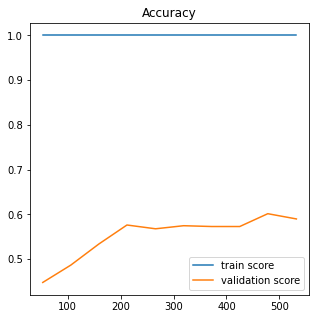

In [ ]:
parameters = { 
    'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
}

kNN_grid = GridSearchCV(kNNPipeline, parameters, scoring='accuracy', n_jobs=-1)
kNN_grid.fit(X_train, y_train)

best_kNN = (kNN_grid.best_estimator_)
best_kNN.fit(X_train,y_train)
# calculating the predictions
y_pred = best_kNN.predict(X_test)

N, train_score, test_score = learning_curve(best_kNN, X_train, y_train, 
                                           cv=10, scoring='accuracy', 
                                           train_sizes=np.linspace(0.1,1,10))
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')
    
plt.figure(figsize=(5,5))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, test_score.mean(axis=1), label='validation score')
plt.legend()
plt.title('Accuracy')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


400 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  

Accuracy =  0.5078740157480315
-
[[52 11  0 15]
 [ 6 25  9  7]
 [17 33 14  7]
 [ 5 13  2 38]]
-
              precision    recall  f1-score   support

         bus       0.65      0.67      0.66        78
        opel       0.30      0.53      0.39        47
        saab       0.56      0.20      0.29        71
         van       0.57      0.66      0.61        58

    accuracy                           0.51       254
   macro avg       0.52      0.51      0.49       254
weighted avg       0.54      0.51      0.49       254

-


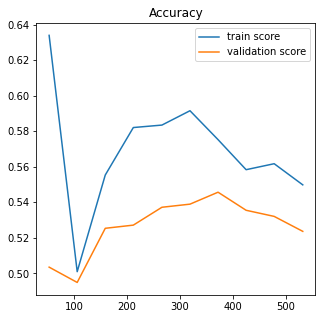

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate_log_regression():
    parameters = {
        'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
        'logisticregression__C': np.logspace(1, 1, 10),
        'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'logisticregression__max_iter': [2000]
    }

    Log_grid = GridSearchCV(LogPipeline, parameters, scoring='accuracy', n_jobs=-1)
    Log_grid.fit(X_train, y_train)

    best_Log = (Log_grid.best_estimator_)
    best_Log.fit(X_train,y_train)
    # calculating the predictions
    y_pred = best_Log.predict(X_test)

    N, train_score, test_score = learning_curve(best_Log, X_train, y_train, 
                                               cv=10, scoring='accuracy', 
                                               train_sizes=np.linspace(0.1,1,10))
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')

    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
evaluate_log_regression()

Παρατηρούμε πως μειώνοντας τις διαστάσεις με PCA, όπως περιμέναμε, μειώνεται η ακρίβεια, αλλά εκπαιδεύονται σε μικρότερο χρονικό διάστημα.

## Τελικά συμπεράσματα

Ο καλύτερος ταξινομητής είναι ο 'Logistic Regression' ενώ ο χειρότερος ταξινομητής είναι ο 'Gaussian Naive-Bayes'.

- Gaussian Naive Bayes

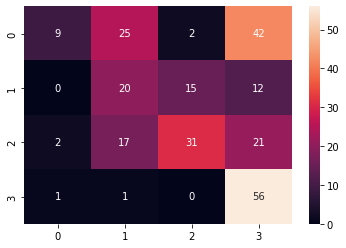

In [ ]:
sns.heatmap(GNB_conf_matr, annot=True)
plt.show()

- Log Regression

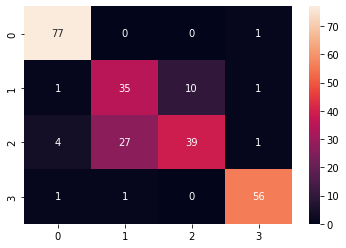

In [ ]:
sns.heatmap(Log_conf_matr, annot=True)
plt.show()

Παρατηρούμε πως ο 'Logistic Regression' είναι καλύτερος από τον 'Gaussian Naive-Bayes', εφόσον ο δεύτερος υποθέτει πως τα χαρακτηριστικά είναι ανεξάρτητα, ενώ ο πρώτος δουλεύει καλύτερα ακόμα και αν τα χαρακτηριστικά έχουν κάποια συσχέτιση.